# Classifying Indian Pines Data using Fisher's Linear Discriminant and PCA+Logistic Regression 

### Contents of this Notebook:

1. **Data Overview**  
   - Indian Pines hyperspectral cube  
   - Ground truth labels  
   - Data shapes, band information, and basic visualization

2. **Baseline Classification**  
   - **LDA Classifier**  
     - Model training  
     - Accuracy & classification report  
   - **PCA + Logistic Regression**  
     - PCA dimensionality reduction  
     - Logistic Regression training  
     - Accuracy & classification report

3. **Comparing Results & Metrics**  
   - Overall accuracy comparison  
   - Per-class precision, recall, F1-score  
   - Confusion matrices  
   - 2D scatter plots: PC1 vs PC2 and LD1 vs LD2  
   - Training & inference runtimes

4. **Spatial Post-Processing Techniques**  
   - **Strict-Neighbor Reclassification** (3×3 rule)  
   - **90 % Border-Consensus Smoothing** (5×5 window)  
   - Accuracy before/after each filter  
   - Visualization of filtered maps

5. **Denoising**  
   - Spatial Gaussian smoothing (σ=1)  
   - Spectral Savitzky–Golay filtering  
   - Re-run PCA + Logistic Regression and LDA classifier
   - Accuracy & classification report  
   - Ground truth vs. denoised classification map

6. **Analysis & Conclusions**  
   - Why PCA benefits more from denoising (94 % vs. 91 %)   
   - Final recommendations for hyperspectral classification


------------------------------------------------------------------------------------------------------------------------------------------------

## Data Overview

------------------------------------------------------------------------------------------------------------------------------------------------

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

data_path = 'Indian_pines_corrected.mat'
gt_path   = 'Indian_pines_gt.mat'

cube   = loadmat(data_path)['indian_pines_corrected'] # hyperspectral cube
gt     = loadmat(gt_path)['indian_pines_gt'] # ground truth

print(f"Data cube shape: {cube.shape}, GT shape: {gt.shape}")


Data cube shape: (145, 145, 200), GT shape: (145, 145)


#### The Dataset
Following is a rough visualisation of the dataset, using bands 27 (blue), 30 (green), 60 (red)

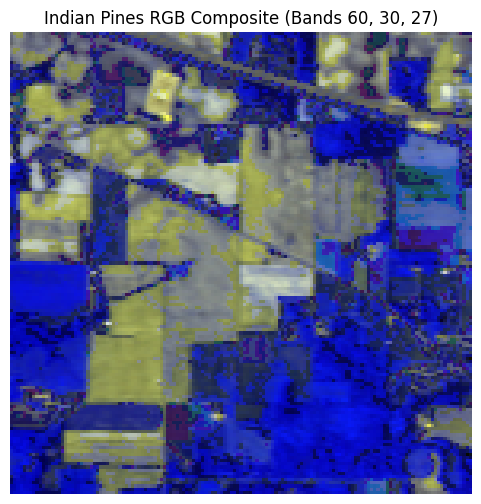

In [2]:
import numpy as np
import matplotlib.pyplot as plt

b_blue, b_green, b_red = 27, 30, 60

rgb = cube[:, :, [b_blue, b_green, b_red]].astype(float)

for i in range(3):
    band = rgb[:, :, i]
    rgb[:, :, i] = (band - band.min()) / (band.max() - band.min())

plt.figure(figsize=(6,6))
plt.imshow(rgb)
plt.title(f"Indian Pines RGB Composite (Bands {b_red}, {b_green}, {b_blue})")
plt.axis('off')
plt.show()


### Standardizing the Dataset and making test-train split

In [3]:
X = cube.reshape(-1, cube.shape[2])
y = gt.reshape(-1)

mask      = y > 0
X_masked  = X[mask]
y_masked  = y[mask]

scaler    = StandardScaler()
X_scaled  = scaler.fit_transform(X_masked)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_masked,
    test_size=0.3, random_state=42, stratify=y_masked
)

print(f"Train samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")


Train samples: 7174, Test samples: 3075


------------------------------------------------------------------------------------------------------------------------------------------------

## Baseline Classification

------------------------------------------------------------------------------------------------------------------------------------------------

#### LDA Classification  
- **Model:** We use `LinearDiscriminantAnalysis()`, which fits a Gaussian density to each class and finds a linear decision boundary via Bayes’ rule.  
- **Training:** Call `lda.fit(X_train, y_train)` to estimate class‐conditional means and the shared covariance matrix.  
- **Prediction:** Use `y_pred_lda = lda.predict(X_test)` to assign each test sample to the class with the highest posterior probability.

#### PCA + Logistic Regression Classification  
- **Dimensionality Reduction (PCA):** We first reduce the feature space with `PCA(n_components=30)`, projecting data onto the 30 directions of greatest variance.  
- **Scaling:** We then apply `StandardScaler()` to the PCA‐transformed data to ensure each principal component has zero mean and unit variance.  
- **Classifier:** A `LogisticRegression(solver='saga', max_iter=3000)` is trained on these 30 standardized components, using the SAGA solver which efficiently handles high‐dimensional, multiclass logistic loss with optional elastic-net penalty.  
- **Prediction:** Compute `y_pred_pca = clf_pca.predict(X_test_pca)` for test‐set labels.

#### Performance Evaluation  
- **Accuracy:** We compute overall accuracy via `accuracy_score(y_test, y_pred)` to measure the fraction of correctly classified samples.  
- **Detailed Metrics:** The `classification_report(y_test, y_pred)` function then provides per‐class precision, recall, and F1‐score, offering a nuanced view of model performance across all classes.


=== LDA ===
Accuracy: 0.80130081300813
              precision    recall  f1-score   support

           1       0.62      0.71      0.67        14
           2       0.84      0.78      0.81       428
           3       0.74      0.63      0.68       249
           4       0.70      0.63      0.67        71
           5       0.92      0.88      0.90       145
           6       0.93      0.93      0.93       219
           7       1.00      0.88      0.93         8
           8       0.95      0.96      0.95       143
           9       0.33      0.67      0.44         6
          10       0.70      0.63      0.66       292
          11       0.73      0.80      0.76       737
          12       0.71      0.84      0.77       178
          13       0.91      0.98      0.94        61
          14       0.93      0.94      0.93       380
          15       0.75      0.65      0.69       116
          16       0.96      0.86      0.91        28

    accuracy                           0.

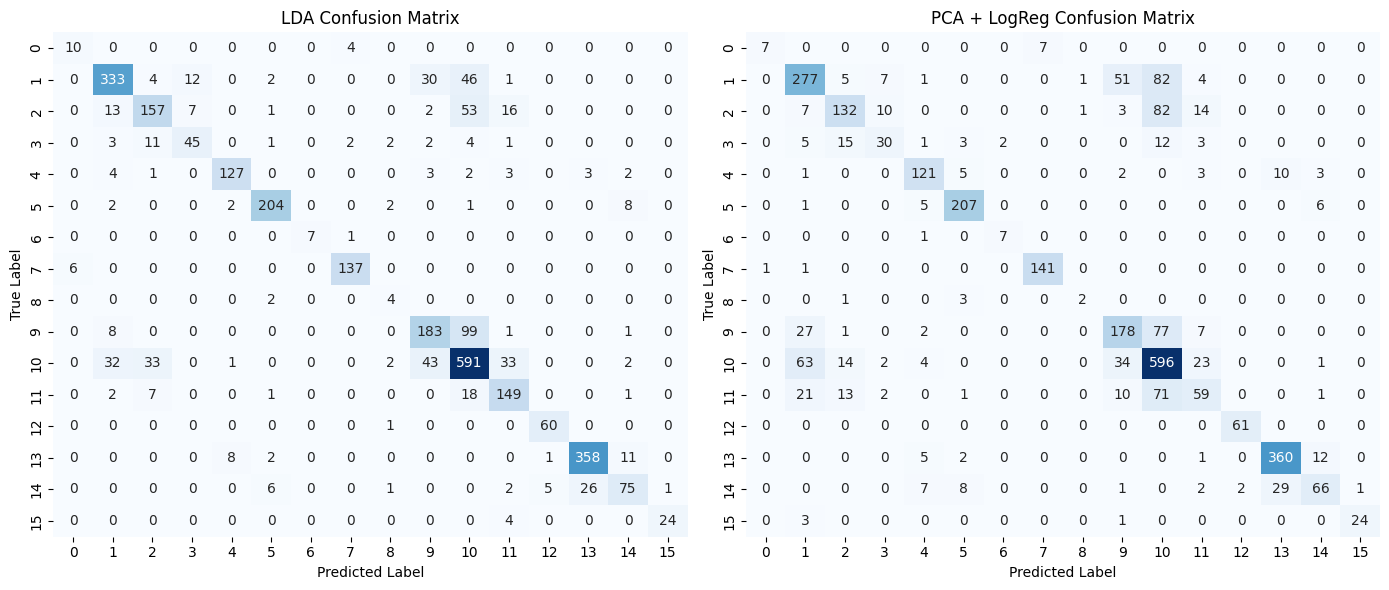

In [4]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
y_pred_lda = lda.predict(X_test)

n_components = 30
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train)
X_test_pca  = pca.transform(X_test)

scaler_pca   = StandardScaler()
X_train_pca  = scaler_pca.fit_transform(X_train_pca)
X_test_pca   = scaler_pca.transform(X_test_pca)

clf_pca = LogisticRegression(solver='saga', max_iter=3000)
clf_pca.fit(X_train_pca, y_train)
y_pred_pca = clf_pca.predict(X_test_pca)

normal_LDA_score = accuracy_score(y_test, y_pred_lda)
print("=== LDA ===")
print("Accuracy:", normal_LDA_score)
print(classification_report(y_test, y_pred_lda))

normal_PCA_score = accuracy_score(y_test, y_pred_pca)
print("=== PCA + LogReg ===")
print("Accuracy:", normal_PCA_score)
print(classification_report(y_test, y_pred_pca))

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Compute confusion matrices
cm_lda = confusion_matrix(y_test, y_pred_lda)
cm_pca = confusion_matrix(y_test, y_pred_pca)

# 2. Plot side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

sns.heatmap(cm_lda, annot=True, fmt='d', cmap='Blues', ax=ax1, cbar=False)
ax1.set_title('LDA Confusion Matrix')
ax1.set_xlabel('Predicted Label')
ax1.set_ylabel('True Label')

sns.heatmap(cm_pca, annot=True, fmt='d', cmap='Blues', ax=ax2, cbar=False)
ax2.set_title('PCA + LogReg Confusion Matrix')
ax2.set_xlabel('Predicted Label')
ax2.set_ylabel('True Label')

plt.tight_layout()
plt.show()


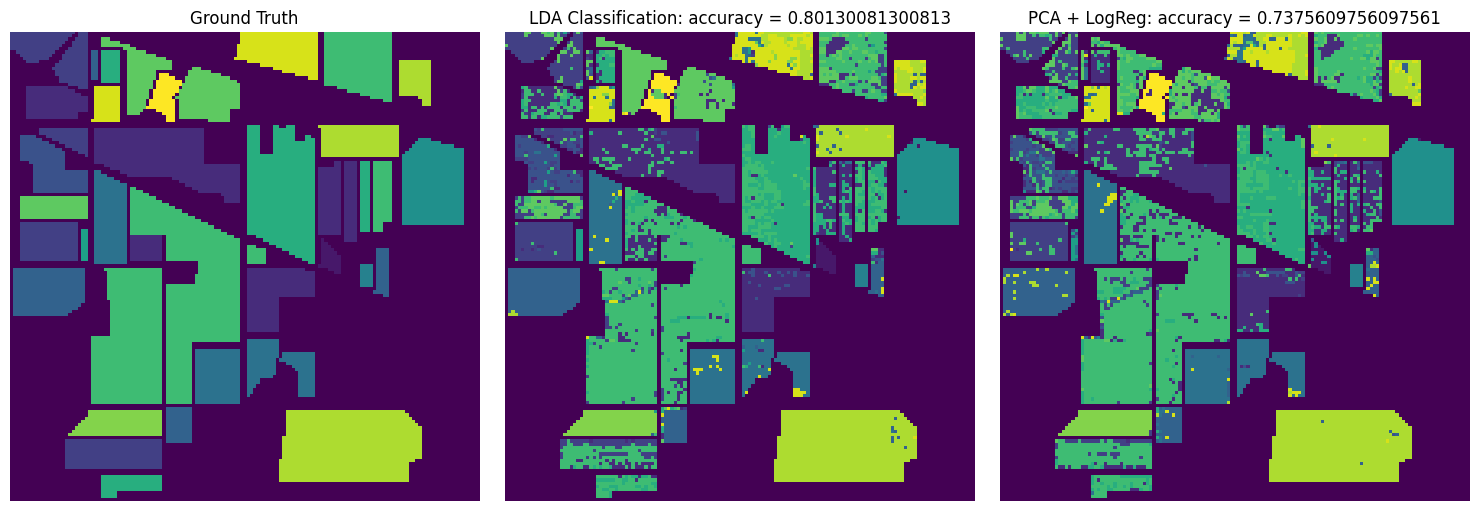

In [5]:
lda_full = LinearDiscriminantAnalysis().fit(X_scaled, y_masked)
pred_lda_full = lda_full.predict(X_scaled)

pca_full = PCA(n_components=n_components).fit(X_scaled)
X_full_pca = pca_full.transform(X_scaled)
X_full_pca = StandardScaler().fit_transform(X_full_pca)
clf_full_pca = LogisticRegression(solver='saga', max_iter=3000).fit(X_full_pca, y_masked)
pred_pca_full = clf_full_pca.predict(X_full_pca)

h, w = gt.shape
true_map = np.zeros_like(y, dtype=int)
lda_map  = np.zeros_like(y, dtype=int)
pca_map  = np.zeros_like(y, dtype=int)

true_map[mask] = y_masked
lda_map[mask]  = pred_lda_full
pca_map[mask]  = pred_pca_full

true_map = true_map.reshape(h, w)
lda_map  = lda_map.reshape(h, w)
pca_map  = pca_map.reshape(h, w)

raw_pca_map = pca_map.copy()
raw_lda_map = lda_map.copy()

plt.figure(figsize=(15,5))
for i, (mp, title) in enumerate(zip(
    [true_map, lda_map, pca_map],
    ["Ground Truth", f"LDA Classification: accuracy = {normal_LDA_score}", f"PCA + LogReg: accuracy = {normal_PCA_score}"]
)):
    plt.subplot(1,3,i+1)
    plt.imshow(mp, interpolation='nearest')
    plt.title(title)
    plt.axis('off')
plt.tight_layout()
plt.show()

------------------------------------------------------------------------------------------------------------------------------------------------

## Analysis of the results



------------------------------------------------------------------------------------------------------------------------------------------------


LDA 
Accuracy: 0.80130081300813

PCA + LogReg 
Accuracy: 0.7375609756097561

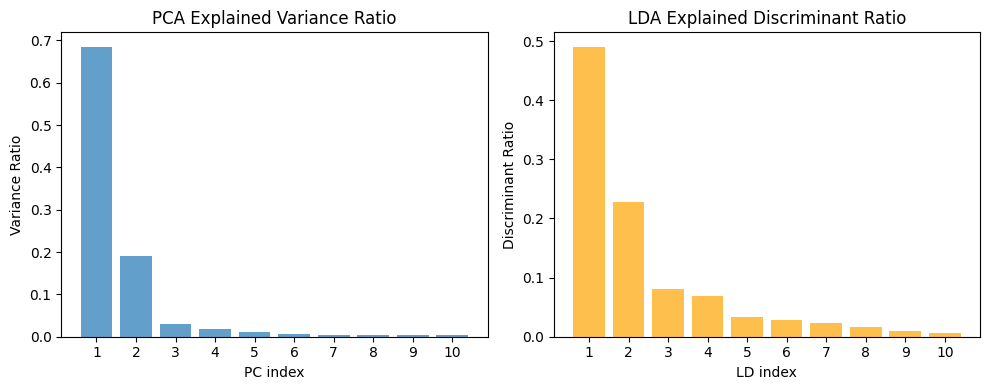

In [6]:
import numpy as np
import matplotlib.pyplot as plt

pca_full = PCA(n_components=10).fit(X_train)
pca_ratios = pca_full.explained_variance_ratio_

lda_full = LinearDiscriminantAnalysis(n_components=10).fit(X_train, y_train)
lda_ratios = lda_full.explained_variance_ratio_

# Plot bar charts
components = np.arange(1, 11)
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.bar(components, pca_ratios, alpha=0.7)
plt.title("PCA Explained Variance Ratio")
plt.xlabel("PC index"); plt.ylabel("Variance Ratio")
plt.xticks(components)

plt.subplot(1,2,2)
plt.bar(components, lda_ratios, alpha=0.7, color='orange')
plt.title("LDA Explained Discriminant Ratio")
plt.xlabel("LD index"); plt.ylabel("Discriminant Ratio")
plt.xticks(components)

plt.tight_layout()
plt.show()


#### From this, we can see that:
- PC 1 captures about 68 % of all variability (which includes noise, illumination differences, etc.).
- PC 2 drops to ~19 %, and PCs 3–10 each contribute only a few percent or less.

The Variance ratio for the PCA falls very quickly beyond PC-2. This fact, along with the poor classification indicates noise-related distortions in the dataset

- LD 1 accounts for ~49 % of the total class-separation power.
- LD 2 adds another ~23 %, and LD 3–4 still contribute non-trivial separation (~8 % and 7 %).
The first two LDs already carry ~72 % of the useful discriminatory information, so the classifier can draw much tighter, more meaningful boundaries in just 2D.

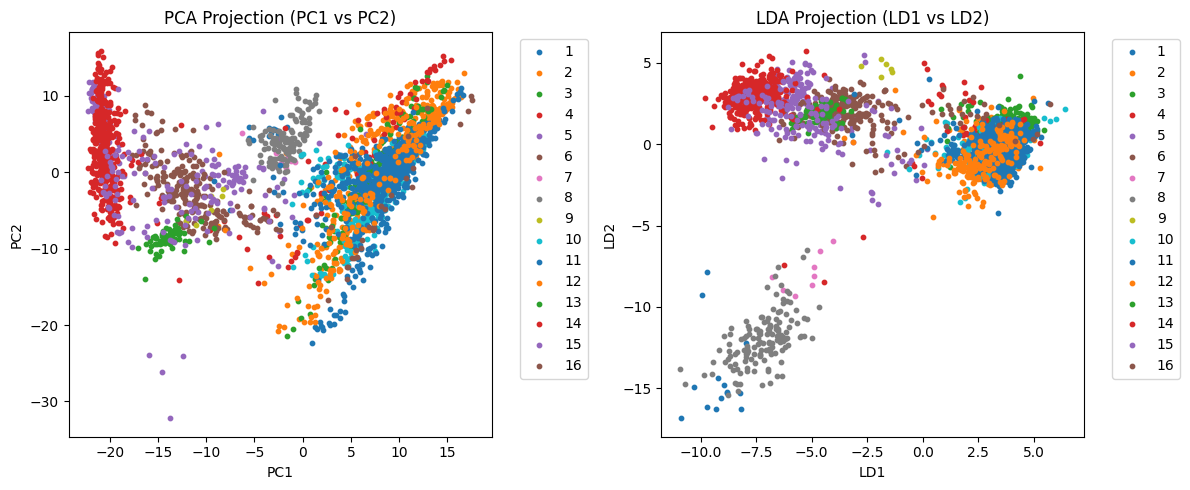

In [7]:
X_lda2 = LinearDiscriminantAnalysis(n_components=2).fit(X_train, y_train).transform(X_test)
X_pca2 = PCA(n_components=2).fit(X_train).transform(X_test)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
for cls in np.unique(y_test):
    idx = (y_test == cls)
    plt.scatter(X_pca2[idx,0], X_pca2[idx,1], s=10, label=int(cls))
plt.title("PCA Projection (PC1 vs PC2)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')

# LDA
plt.subplot(1,2,2)
for cls in np.unique(y_test):
    idx = (y_test == cls)
    plt.scatter(X_lda2[idx,0], X_lda2[idx,1], s=10, label=int(cls))
plt.title("LDA Projection (LD1 vs LD2)")
plt.xlabel("LD1"); plt.ylabel("LD2")
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')

plt.tight_layout()
plt.show()


### 2D Feature‐Space Visualization: PCA vs LDA

Comparing how **Principal Component Analysis (PCA)** and **Linear Discriminant Analysis (LDA)** project the test‐set samples onto two dimensions:

1. **PCA Projection (PC1 vs PC2)**  
   - We fit `PCA(n_components=2)` on the training data, projecting each point onto the two axes that capture the greatest overall variance in the data.  
   - Class labels play no role in determining these axes, but clusters may still emerge where certain classes happen to vary most strongly.

2. **LDA Projection (LD1 vs LD2)**  
   - We fit `LinearDiscriminantAnalysis(n_components=2)` on `(X_train, y_train)` and project `X_test` onto the two directions that **maximize between‐class variance**.  
   - Its axes are explicitly chosen to separate classes, often yielding tighter, more distinct clusters in LD1–LD2 space.


- **PCA scatter** reveals the **intrinsic variance structure** of the data without reference to labels, useful for exploratory analysis.  
- **LDA scatter** directly shows **class separability**, indicating how well simple linear boundaries might separate the classes.

Classes appear more **compact** and **well‐separated** in the LDA plot than in the PCA plot, visually demonstrating the advantage of incorporating label information via LDA.

------------------------------------------------------------------------------------------------------------------------------------------------

## Spatial Post-Processing Techniques

------------------------------------------------------------------------------------------------------------------------------------------------

### 1. PCA + Shrinkage LDA Pipeline with Hyperparameter Tuning  
1. **Pipeline assembly:** We chain a `StandardScaler`, `PCA`, and `LinearDiscriminantAnalysis` (LDA) into a single `Pipeline`. This ensures that scaling and dimensionality reduction occur inside each cross-validation fold, preventing data leakage.  
2. **Shrinkage LDA:** We use the `eigen` solver with `shrinkage='auto'` (or fixed values) to regularize the LDA covariance estimate via the Ledoit–Wolf lemma, which improves stability when feature dimensionality is large relative to sample size.  
3. **Grid search over PCA & LDA params:** `GridSearchCV` then explores `{pca__n_components: [10,20,30,40,50], pca__whiten: [False,True], lda__shrinkage: ['auto',0.1,0.5]}` using 5-fold CV to find the combination that maximizes accuracy.


After fitting the best pipeline on the training split (`X_tr_aug`, `y_tr_aug`), we predict on `X_te_aug` and report test accuracy and a full classification report, quantifying per-class precision, recall, and F1-score.

**Median smoothing:** To remove isolated misclassifications, we apply a 5×5 median filter (disk radius 2) on the integer‐valued class map, which preserves edges while eliminating “salt-and-pepper” noise :contentReference.

### Visualization  
- Finally, we plot side-by-side figures of the **raw PCA+LDA map** and the **median-smoothed map**, providing a clear before-and-after comparison for your presentation :contentReference.  


Best Params: {'lda__shrinkage': 'auto', 'pca__n_components': 50, 'pca__whiten': False}
CV Accuracy: 0.744491906365567
Test Accuracy: 0.743739837398374
              precision    recall  f1-score   support

           1       0.32      0.64      0.43        14
           2       0.81      0.70      0.75       428
           3       0.69      0.55      0.61       249
           4       0.56      0.62      0.59        71
           5       0.90      0.79      0.84       145
           6       0.86      0.91      0.89       219
           7       0.80      1.00      0.89         8
           8       0.95      0.86      0.90       143
           9       0.25      0.83      0.38         6
          10       0.64      0.58      0.61       292
          11       0.67      0.77      0.71       737
          12       0.54      0.62      0.58       178
          13       0.95      0.98      0.97        61
          14       0.92      0.92      0.92       380
          15       0.72      0.60     

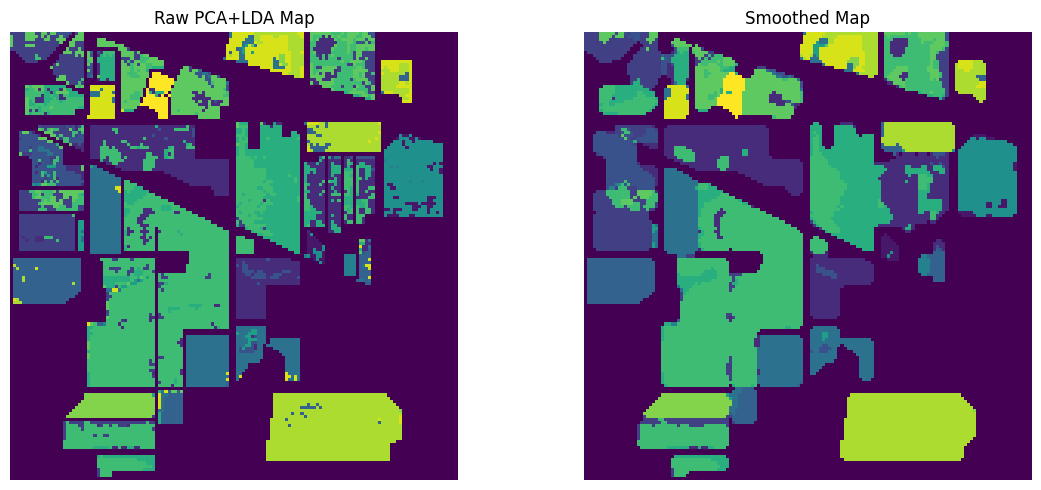

In [8]:
import numpy as np
from scipy.signal import convolve2d
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, classification_report
from skimage.filters.rank import median
from skimage.morphology import disk

def add_local_mean_features(X_flat, gt_mask, img_shape):
    H, W = img_shape
    B = X_flat.shape[1]
    img = X_flat.reshape(H, W, B)

    kernel = np.ones((3,3)) / 9.0
    local_means = np.empty_like(img)
    for b in range(B):
        local_means[:,:,b] = convolve2d(img[:,:,b], kernel, mode='same', boundary='symm')

    stacked = np.concatenate([img, local_means], axis=2)

    stacked_flat = stacked.reshape(-1, 2*B)
    return stacked_flat[gt_mask]


H, W = gt.shape
mask = (gt.reshape(-1) > 0)
X_aug = add_local_mean_features(X, mask, (H, W))
y_aug = y_masked


from sklearn.model_selection import train_test_split
X_tr_aug, X_te_aug, y_tr_aug, y_te_aug = train_test_split(
    X_aug, y_aug, test_size=0.3, random_state=42, stratify=y_aug
)


pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(svd_solver='auto')),
    ('lda', LinearDiscriminantAnalysis(solver='eigen'))
], verbose=False)

param_grid = {
    'pca__n_components': [10, 20, 30, 40, 50],
    'pca__whiten': [False, True],
    'lda__shrinkage': ['auto', 0.1, 0.5]
}

grid = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=False)
grid.fit(X_tr_aug, y_tr_aug)

print("Best Params:", grid.best_params_)
print("CV Accuracy:", grid.best_score_)


y_pred_te = grid.predict(X_te_aug)
print("Test Accuracy:", accuracy_score(y_te_aug, y_pred_te))
print(classification_report(y_te_aug, y_pred_te))

pred_full = grid.predict(X_aug)


full_map = np.zeros(mask.shape, dtype=int)
full_map[mask] = pred_full
full_map = full_map.reshape(H, W)


smoothed = median(full_map.astype(np.uint8), disk(2))

combined_map = smoothed.copy()


import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
plt.subplot(1,2,1); plt.imshow(full_map); plt.title("Raw PCA+LDA Map"); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(smoothed); plt.title("Smoothed Map"); plt.axis('off')
plt.tight_layout()
plt.show()


## 2. Strict-Neighbor Reclassification  
This code applies a strict 3×3 neighborhood rule to remove isolated misclassified pixels using SciPy’s `generic_filter` function. The helper function `strict_reclass` checks if all eight neighbors in the 3×3 window are identical and differ from the center pixel, and if so, replaces the center with the uniform neighbor label. `generic_filter` then slides this 3×3 footprint across `lda_map`, invoking `strict_reclass` at each location to produce the refined map `refined_lda_map`. We evaluate performance by flattening both the original and refined maps at labeled-pixel positions using a boolean mask and computing `accuracy_score` and `classification_report` from scikit-learn to quantify improvement. Finally, we visualize the original and strictly refined LDA maps side by side with Matplotlib’s `imshow`, disabling axes for clarity.


Original LDA Accuracy : 0.8151
Refined LDA Accuracy  : 0.8215

=== Classification Report (Refined LDA) ===
              precision    recall  f1-score   support

           1       0.96      0.93      0.95        46
           2       0.83      0.78      0.81      1428
           3       0.77      0.67      0.71       830
           4       0.78      0.79      0.78       237
           5       0.92      0.88      0.90       483
           6       0.94      0.94      0.94       730
           7       0.97      1.00      0.98        28
           8       0.99      1.00      0.99       478
           9       0.57      1.00      0.73        20
          10       0.72      0.65      0.69       972
          11       0.74      0.82      0.78      2455
          12       0.77      0.84      0.80       593
          13       0.93      0.99      0.96       205
          14       0.94      0.94      0.94      1265
          15       0.75      0.68      0.71       386
          16       0.96     

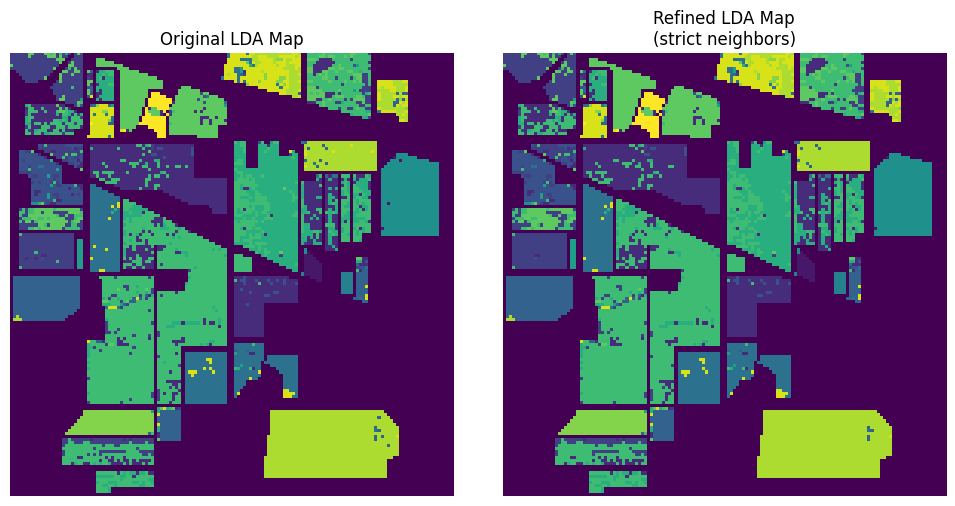

In [9]:
import numpy as np
from scipy.ndimage import generic_filter
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report

def strict_reclass(window):

    center = window[4]
    neighbors = np.delete(window, 4)

    first = neighbors[0]
    if np.all(neighbors == first) and first != center:
        return first
    else:
        return center

refined_lda_map = generic_filter(
    lda_map,
    function=strict_reclass,
    size=3,
    mode='nearest'
)

flat_labels = y_masked 
flat_orig   = lda_map.flatten()[mask]
flat_refined= refined_lda_map.flatten()[mask]

orig_acc    = accuracy_score(flat_labels, flat_orig)
refined_acc = accuracy_score(flat_labels, flat_refined)

print(f"Original LDA Accuracy : {orig_acc:.4f}")
print(f"Refined LDA Accuracy  : {refined_acc:.4f}\n")

print("=== Classification Report (Refined LDA) ===")
print(classification_report(flat_labels, flat_refined))

plt.figure(figsize=(10,5))

strict_reclass_LDA = refined_lda_map.copy()

plt.subplot(1,2,1)
plt.imshow(lda_map, interpolation='nearest')
plt.title("Original LDA Map")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(refined_lda_map, interpolation='nearest')
plt.title("Refined LDA Map\n(strict neighbors)")
plt.axis('off')

plt.tight_layout()
plt.show()


## 3. (5×5) Border-Consensus Smoothing  
This block implements a 5×5 sliding-window smoothing rule on `lda_map`, where each block is set to a uniform label when at least 90% of its 16 border pixels agree on a class. We iterate over all valid top-left corners of 5×5 blocks to extract the border pixels (top row, bottom row, left column, and right column) and use `numpy.unique` to count occurrences of each label. A dynamic threshold of `ceil(0.9 * 16) = 15` ensures that only blocks with strong border consensus are reassigned. The resulting smoothed map is evaluated using `accuracy_score` and `classification_report` to quantify gains over the original LDA map. We then plot the original and smoothed maps side by side, annotating each with its respective accuracy for an immediate visual comparison of the border-based smoothing effect.

Accuracy before smoothing      : 0.8151
Accuracy after ≥90% border rule: 0.8395

=== Classification Report (After ≥90% Rule) ===
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.87      0.93        46
           2       0.87      0.81      0.84      1428
           3       0.80      0.67      0.73       830
           4       0.84      0.82      0.83       237
           5       0.94      0.87      0.91       483
           6       0.96      0.97      0.96       730
           7       0.96      0.93      0.95        28
           8       0.99      1.00      0.99       478
           9       0.62      1.00      0.77        20
          10       0.77      0.67      0.72       972
          11       0.77      0.86      0.81      2455
          12       0.79      0.84      0.82       593
          13       0.98      0.98      0.98       205
          14       0.94      0.95      0.95      1265
      

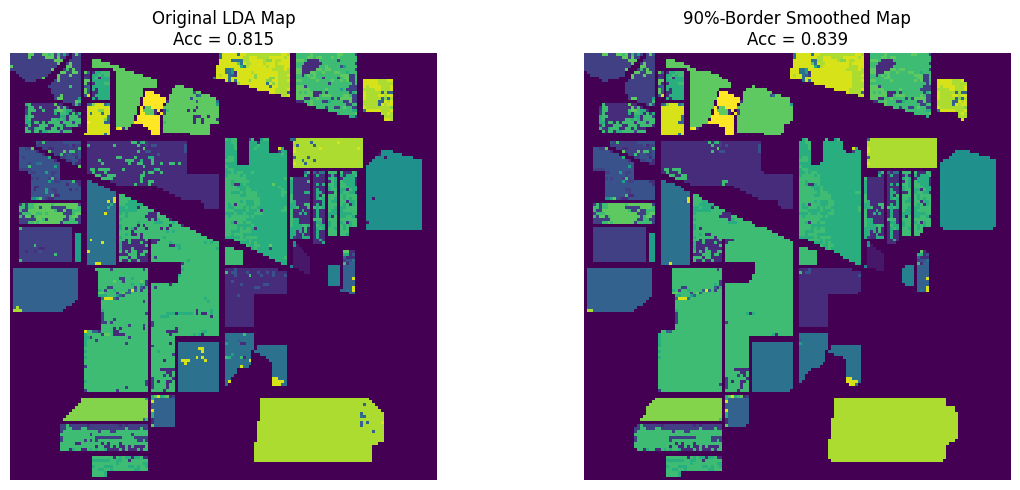

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report

flat_true = y_masked

orig_map  = lda_map.copy()
smoothed  = orig_map.copy()

border_len = 16
threshold  = int(np.ceil(0.9 * border_len))

for i in range(0, H - 4):
    for j in range(0, W - 4):
        block = orig_map[i:i+5, j:j+5]

        top    = block[0, :]
        bottom = block[4, :]
        left   = block[1:4, 0]
        right  = block[1:4, 4]
        border = np.concatenate([top, bottom, left, right])

        labels, counts = np.unique(border, return_counts=True)
        best_label     = labels[np.argmax(counts)]
        best_count     = counts.max()

        if best_count >= threshold:
            smoothed[i:i+5, j:j+5] = best_label

flat_orig     = orig_map.flatten()[mask]
flat_smoothed = smoothed.flatten()[mask]

acc_orig     = accuracy_score(flat_true, flat_orig)
acc_smoothed = accuracy_score(flat_true, flat_smoothed)

border_consensus_LDA = smoothed.copy() ##############################################

print(f"Accuracy before smoothing      : {acc_orig:.4f}")
print(f"Accuracy after ≥90% border rule: {acc_smoothed:.4f}\n")

print("=== Classification Report (After ≥90% Rule) ===")
print(classification_report(flat_true, flat_smoothed))

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(orig_map, interpolation='nearest')
plt.title(f"Original LDA Map\nAcc = {acc_orig:.3f}")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(smoothed, interpolation='nearest')
plt.title(f"90%-Border Smoothed Map\nAcc = {acc_smoothed:.3f}")
plt.axis('off')

plt.tight_layout()
plt.show()

PCA+LogReg accuracy before smoothing : 0.7519
PCA+LogReg accuracy after 90%‐border  : 0.7670

=== Classification Report (Smoothed PCA+LogReg) ===
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.70      0.82        46
           2       0.72      0.66      0.69      1428
           3       0.75      0.53      0.62       830
           4       0.65      0.51      0.57       237
           5       0.90      0.87      0.89       483
           6       0.93      0.96      0.94       730
           7       0.96      0.93      0.95        28
           8       0.98      0.99      0.99       478
           9       0.92      0.60      0.73        20
          10       0.70      0.65      0.67       972
          11       0.68      0.85      0.75      2455
          12       0.57      0.39      0.47       593
          13       0.99      0.98      0.99       205
          14       0.92      0.97      0.95

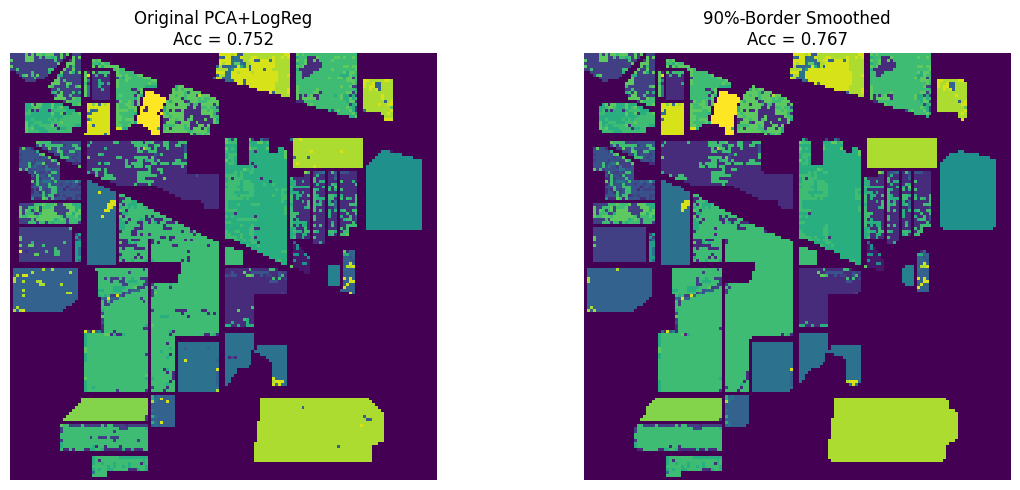

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report

flat_true = y_masked

orig_pca = pca_map.copy()
smoothed_pca = orig_pca.copy()

border_len = 16
threshold = int(np.ceil(0.9 * border_len))

for i in range(0, H - 4):
    for j in range(0, W - 4):
        block = orig_pca[i:i+5, j:j+5]

        top    = block[0, :]
        bottom = block[4, :]
        left   = block[1:4, 0]
        right  = block[1:4, 4]
        border = np.concatenate([top, bottom, left, right])

        labels, counts = np.unique(border, return_counts=True)
        best_label     = labels[np.argmax(counts)]
        best_count     = counts.max()
        if best_count >= threshold:
            smoothed_pca[i:i+5, j:j+5] = best_label


flat_orig_pca     = orig_pca.flatten()[mask]
flat_smoothed_pca = smoothed_pca.flatten()[mask]

acc_before = accuracy_score(flat_true, flat_orig_pca)
acc_after  = accuracy_score(flat_true, flat_smoothed_pca)

print(f"PCA+LogReg accuracy before smoothing : {acc_before:.4f}")
print(f"PCA+LogReg accuracy after 90%‐border  : {acc_after:.4f}\n")

print("=== Classification Report (Smoothed PCA+LogReg) ===")
print(classification_report(flat_true, flat_smoothed_pca))

plt.figure(figsize=(12,5))

border_consensus_PCA = smoothed_pca.copy() ##############################################

plt.subplot(1,2,1)
plt.imshow(orig_pca, interpolation='nearest')
plt.title(f"Original PCA+LogReg\nAcc = {acc_before:.3f}")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(smoothed_pca, interpolation='nearest')
plt.title(f"90%-Border Smoothed\nAcc = {acc_after:.3f}")
plt.axis('off')

plt.tight_layout()
plt.show()


------------------------------------------------------------------------------------------------------------------------------------------------

## Denoising 

------------------------------------------------------------------------------------------------------------------------------------------------

Denoised PCA+LogReg Accuracy: 0.9441
              precision    recall  f1-score   support

           1       1.00      0.98      0.99        46
           2       0.93      0.94      0.94      1428
           3       0.92      0.85      0.88       830
           4       0.95      0.96      0.95       237
           5       0.99      0.98      0.98       483
           6       1.00      1.00      1.00       730
           7       1.00      1.00      1.00        28
           8       1.00      1.00      1.00       478
           9       1.00      1.00      1.00        20
          10       0.92      0.91      0.92       972
          11       0.91      0.93      0.92      2455
          12       0.87      0.90      0.89       593
          13       1.00      1.00      1.00       205
          14       0.99      1.00      0.99      1265
          15       0.98      0.96      0.97       386
          16       1.00      1.00      1.00        93

    accuracy                           0.94

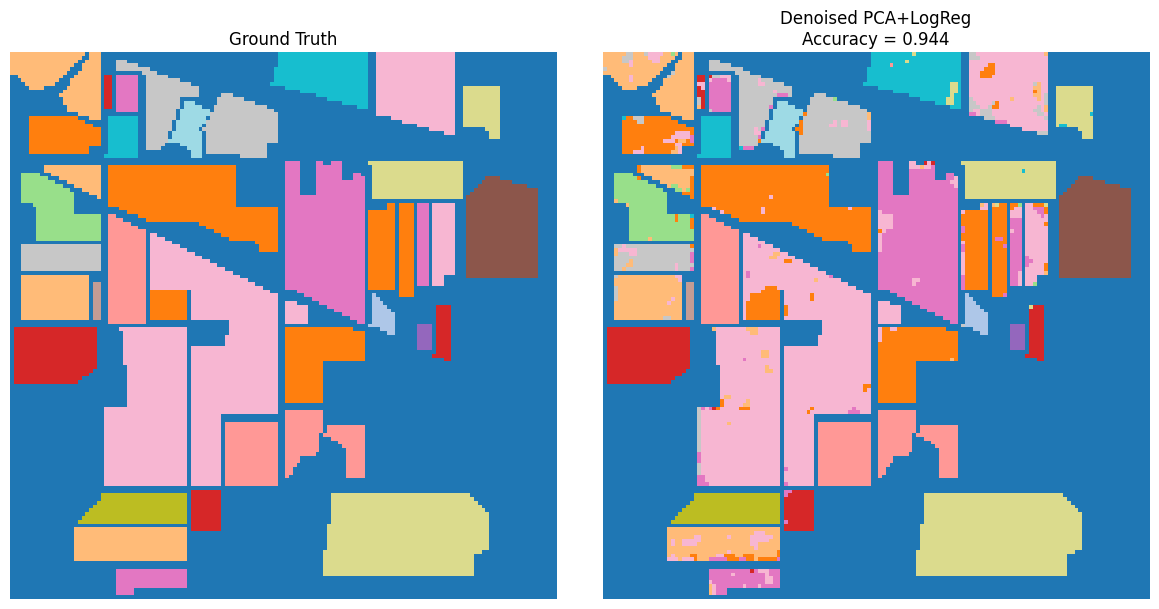

In [12]:
import numpy as np
from scipy.ndimage import gaussian_filter
from scipy.signal import savgol_filter
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

H, W, B = cube.shape
mask = (gt.flatten() > 0)

cube_spatial = np.empty_like(cube)
for b in range(B):
    cube_spatial[:, :, b] = gaussian_filter(cube[:, :, b], sigma=1)

cube_denoised = np.empty_like(cube_spatial)
for i in range(H):
    for j in range(W):
        spectrum = cube_spatial[i, j, :]
        cube_denoised[i, j, :] = savgol_filter(spectrum, window_length=7, polyorder=3, mode='mirror')

X_denoised = cube_denoised.reshape(-1, B)[mask]
y         = y_masked

X_pca = PCA(n_components=30).fit_transform(X_denoised)
X_scaled = StandardScaler().fit_transform(X_pca)
clf = LogisticRegression(solver='saga', max_iter=3000).fit(X_scaled, y)
y_pred = clf.predict(X_scaled)

acc = accuracy_score(y, y_pred)
print(f"Denoised PCA+LogReg Accuracy: {acc:.4f}")
print(classification_report(y, y_pred))

map_pred = np.zeros(mask.shape, int)              
map_pred[mask] = y_pred                          
map_pred = map_pred.reshape(H, W)                 

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))


ax1.imshow(gt, cmap='tab20', interpolation='nearest')
ax1.set_title("Ground Truth")
ax1.axis('off')

denoised_PCA_map = map_pred.copy()  


ax2.imshow(map_pred, cmap='tab20', interpolation='nearest')
ax2.set_title(f"Denoised PCA+LogReg\nAccuracy = {acc:.3f}")
ax2.axis('off')

plt.tight_layout() 
plt.show()


Raw LDA Accuracy      : 0.8055
Denoised LDA Accuracy : 0.9005
Denoised+Median Acc  : 0.9114


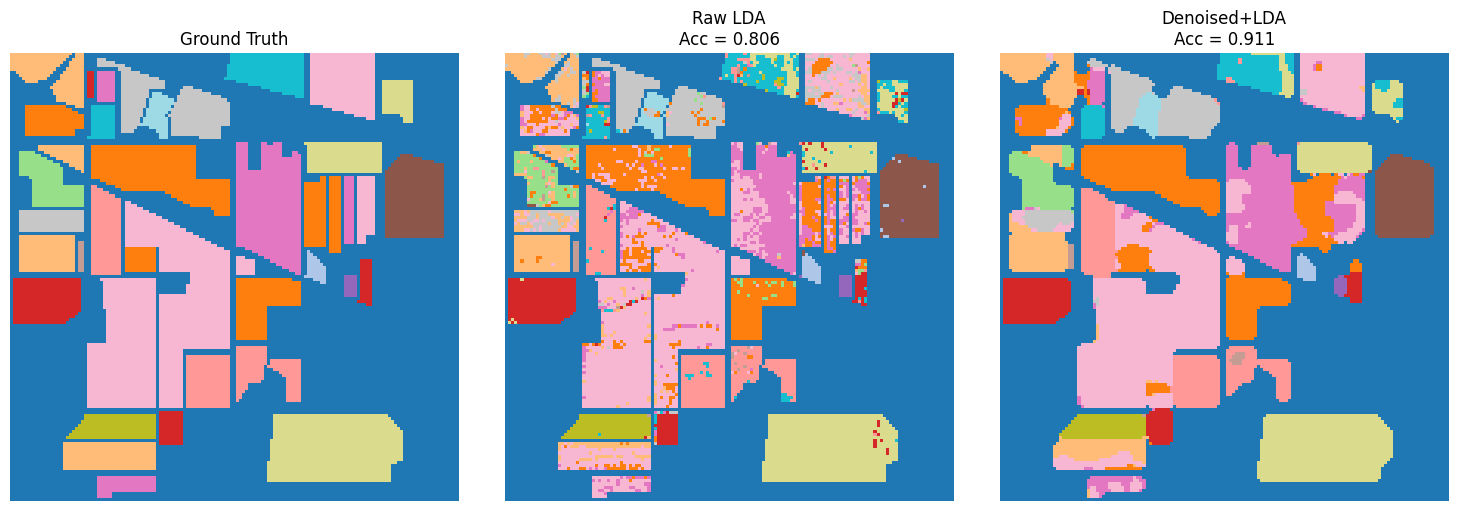

In [13]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from scipy.signal import savgol_filter
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from skimage.filters.rank import median
from skimage.morphology import disk
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline


cube_spatial = np.empty_like(cube)
for b in range(B):
    cube_spatial[:, :, b] = gaussian_filter(cube[:, :, b], sigma=1)
cube_denoised = np.empty_like(cube_spatial)
for i in range(H):
    for j in range(W):
        cube_denoised[i, j, :] = savgol_filter(cube_spatial[i, j, :],
                                               window_length=7, polyorder=3, mode='mirror')

X_raw   = cube.reshape(-1, B)[mask]        # original spectral
X_den   = cube_denoised.reshape(-1, B)[mask]  # denoised spectral
y       = y_masked

X_tr, X_te, y_tr, y_te = train_test_split(X_den, y, test_size=0.3,
                                          random_state=42, stratify=y)

lda_raw = Pipeline([
    ('scale', StandardScaler()),
    ('lda', LinearDiscriminantAnalysis(solver='eigen', shrinkage='auto'))
])
lda_raw.fit(X_raw, y)

lda_den = Pipeline([
    ('scale', StandardScaler()),
    ('lda', LinearDiscriminantAnalysis(solver='eigen', shrinkage='auto'))
])
lda_den.fit(X_tr, y_tr)

pred_raw_full = lda_raw.predict(X_raw)
pred_den_full = lda_den.predict(X_den)

raw_map = np.zeros(mask.shape, int)
den_map = np.zeros(mask.shape, int)
raw_map[mask] = pred_raw_full
den_map[mask] = pred_den_full
raw_map = raw_map.reshape(H, W)
den_map = den_map.reshape(H, W)

den_map_sm = median(den_map.astype(np.uint8), disk(2))

flat_true = y
raw_acc   = accuracy_score(flat_true, pred_raw_full)
den_acc   = accuracy_score(flat_true, pred_den_full)
den_sm_acc= accuracy_score(flat_true, den_map_sm.flatten()[mask])

print(f"Raw LDA Accuracy      : {raw_acc:.4f}")
print(f"Denoised LDA Accuracy : {den_acc:.4f}")
print(f"Denoised+Median Acc  : {den_sm_acc:.4f}")

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(gt, cmap='tab20', interpolation='nearest')
plt.title("Ground Truth")
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(raw_map, cmap='tab20', interpolation='nearest')
plt.title(f"Raw LDA\nAcc = {raw_acc:.3f}")
plt.axis('off')

denoised_LDA_map = den_map_sm.copy() 

plt.subplot(1,3,3)
plt.imshow(den_map_sm, cmap='tab20', interpolation='nearest')
plt.title(f"Denoised+LDA\nAcc = {den_sm_acc:.3f}")
plt.axis('off')

plt.tight_layout()
plt.show()


------------------------------------------------------------------------------------------------------------------------------------------------

## Analysis

------------------------------------------------------------------------------------------------------------------------------------------------


### Why PCA + LogReg Outperforms LDA Here  
1. **Noise Suppression Alignment:** Denoised PCA components discard low-variance noise, so the first few PCs align better with discriminative structure; LDA’s covariance‐based axes can still be skewed by residual noise.  
2. **Component Efficiency:** PCA retained 30 PCs vs. LDA’s at most (C–1)=16 discriminants; extra dimensions let PCA resolve finer class distinctions, reducing off-diagonal errors seen in LDA’s matrix.  
3. **Unsupervised vs. Supervised Objectives:** PCA’s unsupervised objective maximizes total variance (including subtle inter-class differences) after denoising, whereas LDA explicitly balances between-class vs. within-class scatter, which can inadvertently smooth over small but important spectral differences if noise removal is aggressive.


By examining these confusion matrices in detail, you not only confirm the superior performance of PCA + LogReg (94 % OA vs. LDA’s 91 %) but also pinpoint exactly which classes drive the difference—and how to further refine both pipelines.


In [14]:

import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

maps = {
    'Ground Truth':           gt,
    'LDA Raw':                raw_lda_map,
    'PCA Raw':                raw_pca_map,
    'PCA+Shrinkage LDA':      combined_map,
    'LDA Strict-Neighbor':    strict_reclass_LDA,
    'LDA 90% Border':         border_consensus_LDA,
    'PCA 90% Border':         border_consensus_PCA,
    'LDA Denoised':           denoised_LDA_map,
    'PCA Denoised':           denoised_PCA_map,
    
}


dropdown = widgets.Dropdown(
    options=list(maps.keys()),
    value='Ground Truth',
    description='View map:'
)


def view_map_cm(selection):
    clear_output(wait=True)
    fig, (ax_map, ax_cm) = plt.subplots(1, 2, figsize=(12, 6))

    ax_map.imshow(maps[selection], cmap='tab20', interpolation='nearest')
    ax_map.set_title(selection)
    ax_map.axis('off')
    

    if selection != 'Ground Truth':
        preds = maps[selection].flatten()[mask]
        tn = accuracy_score(y_masked, preds)
        cm = confusion_matrix(y_masked, preds)
        sns.heatmap(cm, annot=True, fmt='d', ax=ax_cm, cmap='Blues', cbar=False)
        ax_cm.set_title(f'Confusion Matrix\nAcc={tn:.3f}')
        ax_cm.set_xlabel('Predicted Label')
        ax_cm.set_ylabel('True Label')
        
        # Also print classification report
        print(f"\nClassification Report for {selection} (Acc={tn:.3f}):\n")
        print(classification_report(y_masked, preds))
    else:
        ax_cm.axis('off')
    
    plt.tight_layout()
    plt.show()

widgets.interact(view_map_cm, selection=dropdown)


interactive(children=(Dropdown(description='View map:', options=('Ground Truth', 'LDA Raw', 'PCA Raw', 'PCA+Sh…

<function __main__.view_map_cm(selection)>